#Guillermo Gallego Reina - Sales Forecasting

Se busca pronosticar las ventas de las miles de familias de productos que se venden en las tiendas ubicadas en Ecuador. 

El conjunto de datos utilizado tiene como variable target("transactions") y ha sido obtenido https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=holidays_events.csv.

El objetivo es definir un problema de machine learning llevando a cabo el proceso de limpieza de datos, ingeniería de variables, análisis exploratorio proporcionando algunas ideas, preparar los datos y entrenar un modelo de aprendizaje automático para Series Temporales.

En este caso se realizará usando pyspark para todo el proceso.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql.functions import *
from dateutil.relativedelta import relativedelta
import pyspark.sql.functions as F
import pandas as pd
import pyspark.pandas as ps
import missingno as msno

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import acf

In [0]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    """
    Funcion para  realizar las metricas de evaluacion de las prediciones.
    """
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [0]:
#transactions_sales
  
 #|-- date: timestamp (nullable = true) -> Tenemos las fechas desde [2017-08-15, 2013-01-01]
 #|-- store_nbr: integer (nullable = true)  -> Codigo de tiene, tenemos un total de 54.
 #|-- transactions: integer (nullable = true) -> Transaciones que se han realizado, sales por cada fecha.

#Lectura de Datos

In [0]:
df = spark.sql("SELECT * FROM transactions_sales")
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- transactions: integer (nullable = true)



In [0]:
#Descripcion de las variables estadisticas
df.describe().show()

+-------+------------------+------------------+
|summary|         store_nbr|      transactions|
+-------+------------------+------------------+
|  count|             83488|             83488|
|   mean|26.939236776542735|1694.6021583940208|
| stddev|15.608203645366135| 963.2866435167193|
|    min|                 1|                 5|
|    max|                54|              8359|
+-------+------------------+------------------+



#Analisis Descriptivo

###Transaciones por Tienda

In [0]:
px.line(df.toPandas().sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transaciones por tienda" )

###Transaciones por Meses y Año

In [0]:
a = df.toPandas().copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transaciones por Meses y Año")

###Transacciones promedio mensuales

In [0]:
a = df.toPandas().set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions" )

###Transacciones por año y día de la semana

In [0]:
a = df.toPandas().copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transaciones por año y dia de la semana")

## Modelado Clasico

Los modelos estadísticos para series temporales que tienen en cuenta la dependencia existente entre los datos, esto es, cada observación en un momento dado es modelada en función de los valores anteriores.

Los modelos se conocen con el nombre genérico de **ARIMA (AutoRegresive Integrated Moving Average)(ARIMA para procesos estocásticos no estacionarios y ARMA para procesos estocásticos estacionarios)**, que deriva de sus tres componentes Autoregresivo, Integrado y Medias Móviles:

* **Procesos Autoregresivos AR(p)**
***Los modelos autoregresivos se basan en la idea de que el valor actual de la serie, Xt, puede explicarse o predecirse en función de p valores pasados Xt-1, ... Xt-p más un término de error, donde p determina el número de valores pasados necesarios para pronosticar un valor actual***. El orden del modelo expresa el número de observaciones retrasadas de la serie temporal que intervienen en la ecuación, así pues, un modelo autoregresivo de orden 1 AR(1), la variable Xt está determinada únicamente por un valor pasado, esto es Xt-1 y así sucesivamente. Todos los procesos autorregresivos son procesos invertibles. Xt=f0+f1Xt-1+f2Xt-2+......+fpXt-p+at

* **Procesos de Medias Móviles MA(q)**
Un modelo de medias móviles es aquel que explica el valor de una determinada variable en un período t en función de un término independiente y una sucesión de errores correspondientes a períodos precedentes, ponderados convenientemente. Estos modelos se denotan normalmente con las siglas MA, seguidos del orden entre paréntesis. Todos los procesos de medias móviles son procesos estacionarios. No todos los procesos de medias móviles son invertibles. Xt=m+at+q1at-1+q2at-2+......+qpat-p

* **Proceso Autoregresivo de Medias Móviles ARMA(p,q)**
Una extensión natural de los modelos AR(p) y MA(q) es un tipo de modelos que incluyen tanto términos autorregresivos como de medias móviles. Los modelos autorregresivos de medias móviles, ARMA(p,q), son la suma de un proceso autorregresivo de orden p y uno de medias móviles de orden q. Es muy probable que una serie de tiempo tenga características de AR y de MA a la vez y, por consiguiente, sea ARMA. Un proceso ARMA(p, q) es estacionario si lo es su componente autorregresiva, y es invertible si lo es su componente de medias móviles.

* **Proceso Integrado I(d)**
No todas las series temporales son estacionarias, algunas presentan cambios de nivel en el tiempo o la varianza no es constante, por lo que la serie se diferencia d veces para hacerla estacionaria. A este tipo de procesos se les considera procesos integrados, y se puede aplicar a esta serie diferenciada un modelo ARMA(p,q) para dar lugar a un modelo ARIMA(p,d,q).

##Primero Pasos

Esta primera fase consiste en identificar el posible modelo ARIMA(p,d,q) que sigue la serie (es posible identificar más de un modelo candidato que pueda describir la serie), lo que requiere:

* **Generalmente en primer lugar se debe de representar gráficamente la serie para identificar la tendencia y la estacionalidad** (si es que las hay)(la estacionalidad de puede ver con las gráficas de las subsecuencias estacionarias).

* **Posteriormente se prosigue modelando y eliminando tanto la tendencia como la estacionalidad para conseguir la estacionariedad** (sobre todo si son muy pronunciadas y se ve claramente que existen)


  * **En caso de observarse un componente estacional muy fuerte además de tendencia,** se puede probar a eliminar primero el componente estacional por si la serie resultante ya fuera estacionaria, y así no tener que realizar además la eliminación de la tendencia, también pueden no eliminarse directamente e incluirse las diferenciaciones necesarias para hacerlo en el modelo ARIMA.


***Lo recomendable es llegar al análisis de tendencia y estacionalidad con la serie temporal lo mas limpia posible, eliminando todo tipo de comportamientos no deseados, luego si al graficar la serie vemos claramente que es heterocedástica (no es constante en varianza)(es frecuente observar que la varianza aumenta con el nivel de la serie)(por lo tanto no sigue una distribución normal) es recomendable realizar alguna de las siguientes transformaciones para acercarse más a una distribución normal:***

  * **Transformación logarítmica:** consiste en aplicar a los datos de la serie original un logaritmo de forma. Los valores pequeños se expandirán y los grandes se contraeran. Solo se puede llevar a cabo con valores positivos (aunque esto se soluciona sumando una constante a los valores). Una transformación logaritmica se deshace con una transformación exponencial.
  
  * **Transformación de Box-Cox:** al igual que la anterior, son una familia de transformaciones potenciales para corregir sesgos en la distribución de errores, varianzas desiguales y principalmente para corregir la no linealidad en la relación (mejorar correlación entre las variables). La diferencia está en que se emplea e identifica un parámetro lambda que va a representar el mejor valor para elevar los datos que aumenta la normalidad

###Caso de Uso

**En el caso de uso, vamos a calcular las transaciones totales por meses, eliminando las tiendas.**

In [0]:
dftransac = df.select('date','transactions').groupby('date').agg(sum("transactions").alias("total_transactions")).orderBy(col("date").desc())

dftransac = dftransac.withColumn('date',F.when(F.to_date(F.col("date"),"dd/MM/yyyy").isNotNull(),
         F.date_format(F.to_date(F.col("date"),"dd/MM/yyyy"),"yyyy-MM-dd")).otherwise(F.col('date')))

#Agrupamos por mese y anio
dftransac = dftransac.groupBy(year('date').alias('year'),month('date').alias('month')).agg(sum("total_transactions").alias("total_transactions_month"))

dftransac = dftransac.withColumn('year', col("year").cast(StringType()))
dftransac = dftransac.withColumn('month', col("month").cast(StringType()))

dftransac = dftransac.withColumn('date_new',concat(col('year'),lit('-'),col('month'),lit('-'),lit('1')))

dftransac = dftransac.withColumnRenamed('date_new', 'date')
#Transformamos a date
dftransac = dftransac.withColumn('date',F.when(F.to_date(F.col("date"),"dd/MM/yyyy").isNotNull(),
         F.date_format(F.to_date(F.col("date"),"dd/MM/yyyy"),"yyyy-MM-dd")).otherwise(F.col('date')))



##Tendencia y Estacionalidad

In [0]:
dftransacpan = dftransac.toPandas()
dftransacpan['date'] = dftransacpan['date'].apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d'))
dftransacpan = dftransacpan.sort_values(by='date').reset_index(drop=True)
#Eliminamos outlier que se ha indentificado
dftransacpan = dftransacpan[dftransacpan['date'] < datetime.datetime(2017,8,1)]

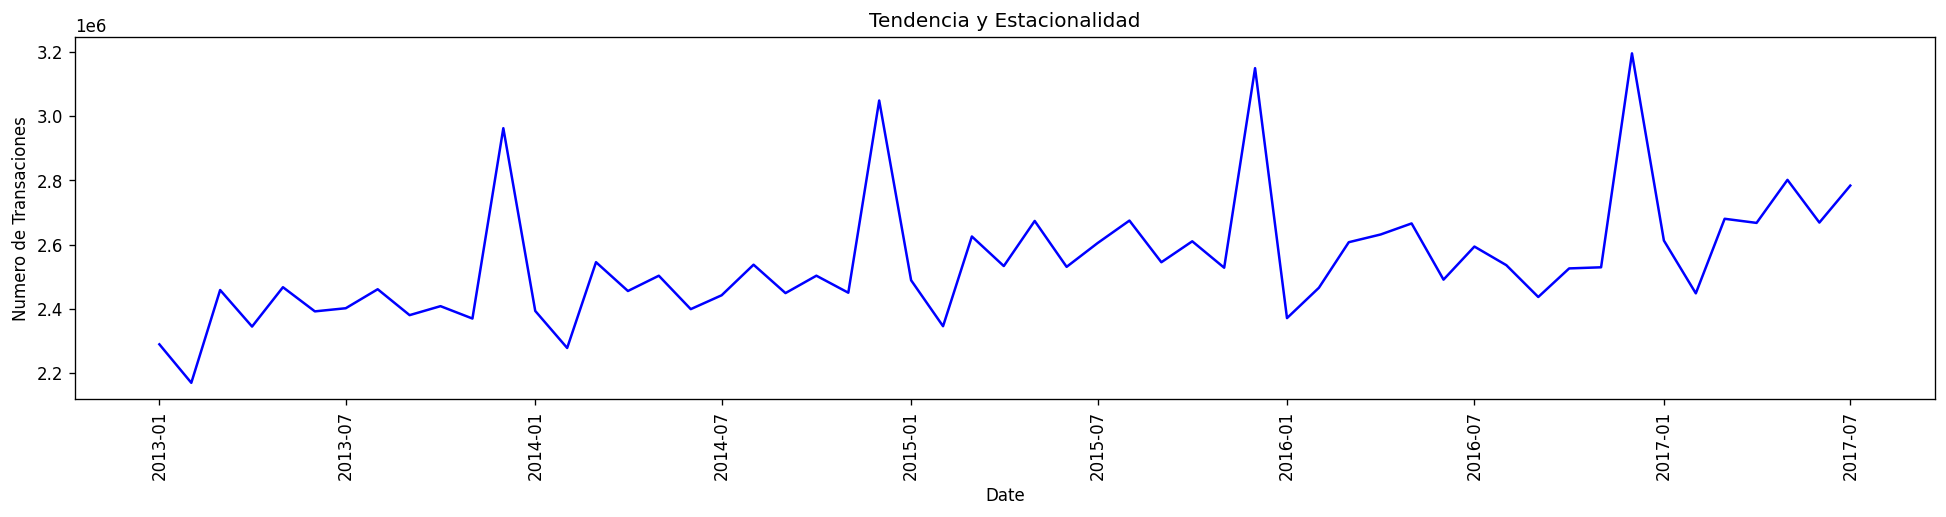

In [0]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Numero de Transaciones'):
    plt.figure(figsize=(20,4))
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.show()
    

    
plot_df(dftransacpan, x=dftransacpan['date'], y=dftransacpan['total_transactions_month'], title='Tendencia y Estacionalidad')

##Comentarios Tendencia y Estacionalidad:


* Mantiene una estacionalidad durante todos los meses del año exceptuando el mes 12 que sube.
  
**Conclusiones: Estacionalidad y Tendencia**

* Desde los meses 11 al 12 (Tendencia Ascendente)
* Desde los meses del 12 al 1 (Tendencia Descenente)

**Dado que tenemos estacionalidad y tendencia vamos a eliminar estos para conseguir la estacionariedad (sobre todo si son muy pronunciadas y se ve claramente que existen). En caso de observarse un componente estacional muy fuerte además de tendencia, se puede probar a eliminar primero el componente estacional por si la serie resultante ya fuera estacionaria, y así no tener que realizar además la eliminación de la tendencia, también pueden no eliminarse directamente e incluirse las diferenciaciones necesarias para hacerlo en el modelo ARIMA.**

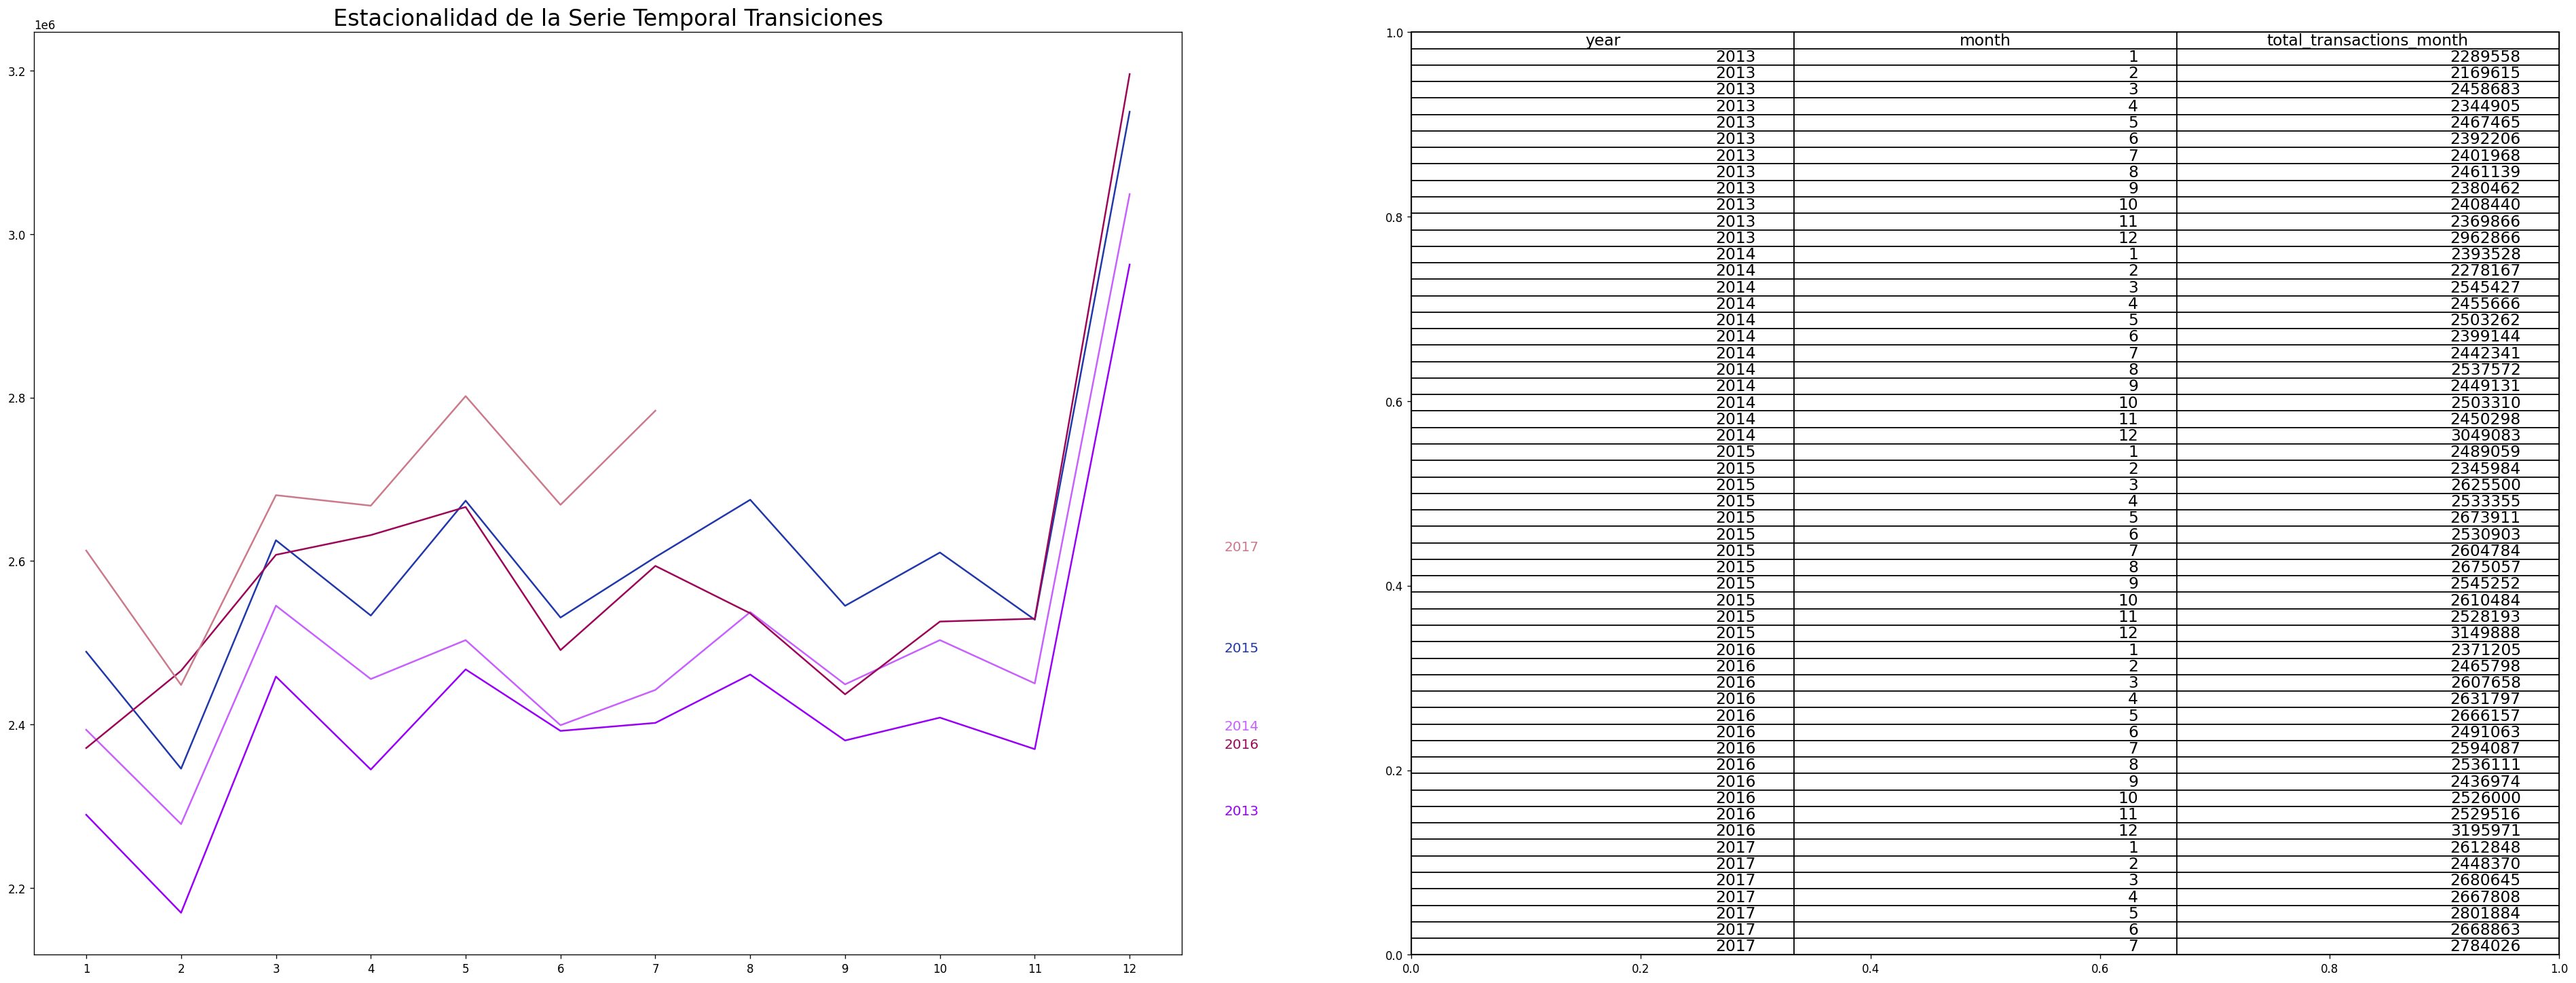

<Figure size 1280x960 with 0 Axes>

In [0]:
years = dftransacpan['year'].unique()
import matplotlib.colors as mcolors
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mcolors.XKCD_COLORS.keys()), len(years), replace=False,)

# Draw Plot
fig, ax = plt.subplots(1,2,figsize=(40,15))
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):      
  ax[0].plot('month', 'total_transactions_month', data=dftransacpan.loc[dftransacpan.year==y, :], color=mycolors[i], label=y)
  ax[0].text(12, dftransacpan.loc[dftransacpan.year==y, 'total_transactions_month'][:-1].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
ax[0].set_title("Estacionalidad de la Serie Temporal Transiciones", fontsize=20)


dr = dftransacpan[['year','month','total_transactions_month']]
font_size=14
bbox=[0, 0, 1, 1]
mpl_table = ax[1].table(cellText = dr.values, bbox=bbox, colLabels=dr.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

plt.show()

##¿Cómo hacer que una serie de tiempo sea estacionaria?

* Podemos aplicar algún tipo de transformación para hacer que la serie temporal sea estacionaria. Estas transformaciones pueden incluir:
  * Diferenciando la Serie (una o más)
  * Toma el registro de la serie.
  * Saca la raíz enésima de la serie
  * Combinación de lo anterior

**El método más comúnmente usado y conveniente para estacionarizar la serie es diferenciar la serie al menos una vez hasta que se vuelva aproximadamente estacionaria.**

##Comprobar si un serie es Estacionaria


Verificaremos si la serie temporal es estacionaria utilizando la prueba de **Dickey Fuller aumentada (ADF Test)**, del paquete statsmodels. La razón es que necesitamos diferenciar solo si la serie no es estacionaria. De lo contrario, no se necesita diferenciación, es decir, d=0.


Test de Hipotesis (ADF):

* **La hipótesis nula (Ho)** en este test es que la serie no es estacionaria, luego si el valor resultante, p-value, es menor de 0.05 (ya que el p-value representa la probabilidad de la hipótesis tomada) indica que la serie es estacionaria con un nivel de confianza del 95% (en caso contrario no habría evidencia para rechazar la hipótesis de no estacionariedad).

In [0]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(dftransacpan['total_transactions_month'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#Dado que obtenemos un resultado mayor que 0.05 que es el nivel de significacion diremos que nuestra serie temporal no es estacionaria y por lo tanto tenemos que buscar la diferenciacion.

ADF Statistic: -1.022235
p-value: 0.745068


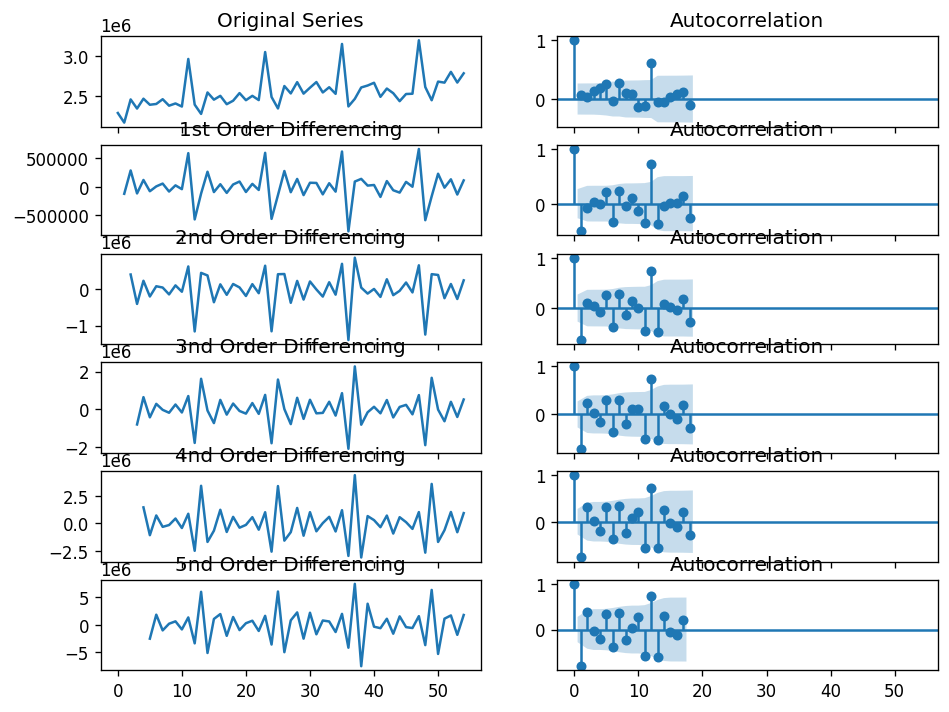

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(6, 2, sharex=True)
axes[0, 0].plot(dftransacpan['total_transactions_month']); axes[0, 0].set_title('Original Series')
plot_acf(dftransacpan['total_transactions_month'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dftransacpan['total_transactions_month'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dftransacpan['total_transactions_month'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(dftransacpan['total_transactions_month'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dftransacpan['total_transactions_month'].diff().diff().dropna(), ax=axes[2, 1])

# 3nd Differencing
axes[3, 0].plot(dftransacpan['total_transactions_month'].diff().diff().diff()); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(dftransacpan['total_transactions_month'].diff().diff().diff().dropna(), ax=axes[3, 1])

# 4nd Differencing
axes[4, 0].plot(dftransacpan['total_transactions_month'].diff().diff().diff().diff()); axes[4, 0].set_title('4nd Order Differencing')
plot_acf(dftransacpan['total_transactions_month'].diff().diff().diff().diff().dropna(), ax=axes[4, 1])
# 5nd Differencing
axes[5, 0].plot(dftransacpan['total_transactions_month'].diff().diff().diff().diff().diff()); axes[5, 0].set_title('5nd Order Differencing')
plot_acf(dftransacpan['total_transactions_month'].diff().diff().diff().diff().diff().dropna(), ax=axes[5, 1])

plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con 1 órden de diferenciación.

##Segundo Paso

Una vez que la serie sea estacionaria(Stacionarity), se determina un modelo ARIMA (o ARMA en caso de que no haga falta diferenciar) para la serie estacionaria, es decir, los órdenes p, d y q de su estructura autorregresiva, integrado y de media móvil. El modelo se puede deducir leyendo los correlogramas de la serie, es decir, las funciones de autocorrelación y autocorelación parcial (de la serie transformada, no de la original), ya que por norma general cuando solo hay un componente

- **Calculo del valor p:** Los modelos AR tienen un ACF que decrece rápidamente a 0 (con diferentes posibles formas: regulares, sinusoidales, anternando +/-). El número del orden “p” (AR(p)) puede ser tantos valores “distintos de 0 como haya en el PACF” o el lag del mayor rezago significativo (hay que sopesar la capacidad predictiva que se puede ganar frente a al ruido que se pueda añadir).

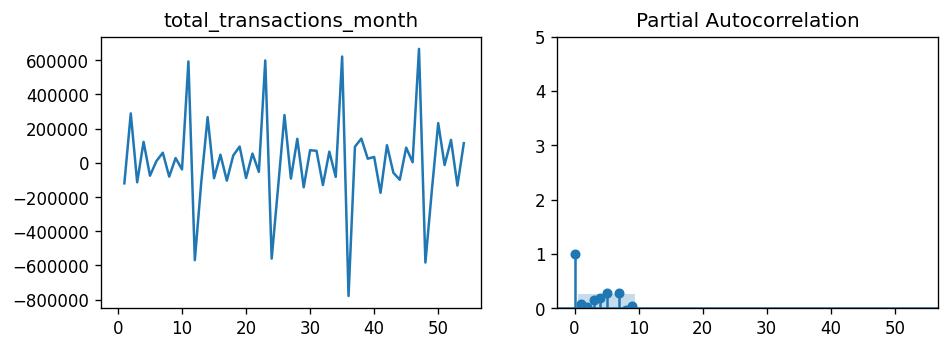

In [0]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(dftransacpan['total_transactions_month'].diff().dropna()); axes[0].set_title('total_transactions_month')
axes[1].set(ylim=(0,5))
plot_pacf(dftransacpan['total_transactions_month'], ax=axes[1], lags=9)
plt.show()

Al ejecutar el ejemplo, podemos ver que existe una correlación positiva con los primeros retrasos que quizás sea significativa para los primeros.

Un buen punto de partida para el parámetro AR del modelo puede ser 1.

- **Calculo de q:** Los modelos MA tiene un PACF que decrece rápidamente a 0 (con diferentes posibles formas: regulares, sinusoidales, anternando +/-)(aunque generalmente no ayuda a establecer el orden). El número del orden “q” (MA(q)) es tantos “valores distintos de 0” como haya en el ACF, o el lag del mayor rezago significativo (hay que sopesar la capacidad predictiva que se puede ganar frente a al ruido que se pueda añadir).

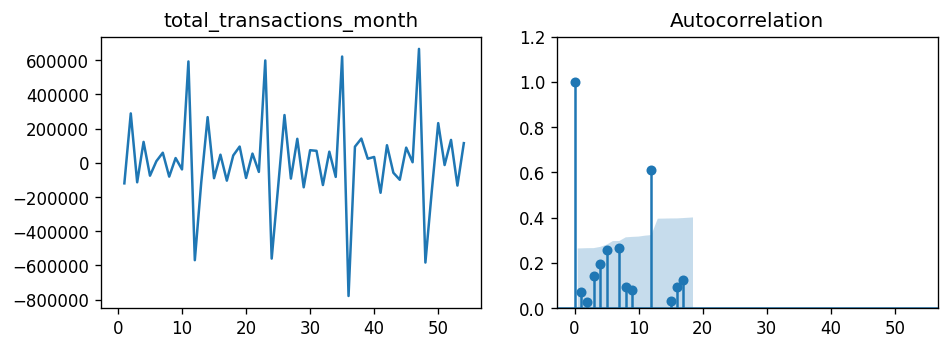

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(dftransacpan['total_transactions_month'].diff().dropna()); axes[0].set_title('total_transactions_month')
axes[1].set(ylim=(0,1.2))
plot_acf(dftransacpan['total_transactions_month'], ax=axes[1])

plt.show()

Al ejecutar el ejemplo, podemos ver que existe una correlación positiva con los primeros retrasos que quizás sea significativa para los primeros.

Un buen punto de partida para el parámetro AR del modelo puede ser 0.

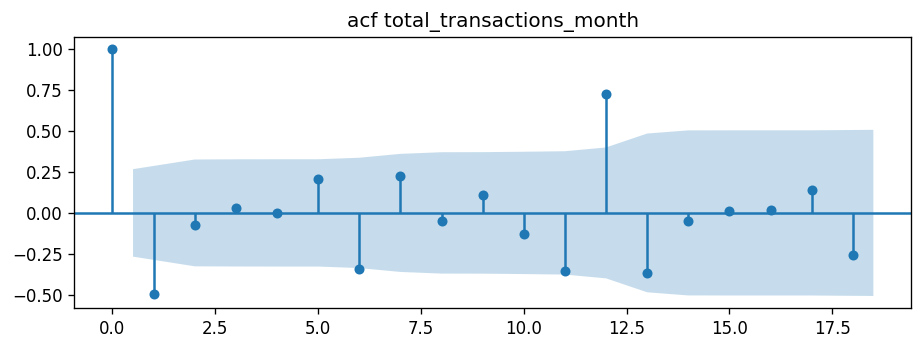

In [0]:
plot_acf(dftransacpan['total_transactions_month'].diff().dropna())
plt.title('acf total_transactions_month')
plt.show()

##Tercer Paso

Una vez definidos los parametros realizamos la Estimación.

**Estiamacion:** una vez seleccionado provisionalmente un modelo para la serie estacionaria, se pasa a la segunda etapa, donde se estiman los coeficientes/parámetros de los términos autorregresivos (AR) y de media móvil (MA) del modelo (siempre el modelo estacionario, no el original). Los parámetros se suelen obtener por máxima verosimilitud o por mínimos cuadrados lineales, pero en otras ocasiones se recurre a la estimación no lineal de los parámetros, el objetivo en ambos casos es encontrar los valores de los parametros que minimizen el sumatorio de los errores al cuadrado (o dicho de otra forma, minimizar la suma de los cuadrados de los residuos).

Los parámetros del modelo ARIMA se definen de la siguiente manera:

* **p:** El número de observaciones de retraso incluidas en el modelo, también llamado orden de retraso.
* **d:** El número de veces que se diferencian las observaciones sin procesar, también llamado grado de diferenciación.
* **q:** El tamaño de la ventana del promedio móvil, también llamado orden del promedio móvil.

#Automatizar el modelo ARIMA

* **En Python, el paquete pmdarima proporciona la función auto_arima() que se puede utilizar para automatizar el proceso de ARIMA Forecasting en Python.**

* **El algoritmo auto-ARIMA busca identificar los parámetros más óptimos para un modelo ARIMA, decidiéndose por un solo modelo ARIMA ajustado. Este proceso se basa en la función R de uso común, forecast::auto.arima.**

* **Auto-ARIMA funciona mediante la realización de pruebas de diferenciación (es decir, Kwiatkowski–Phillips–Schmidt–Shin, Dickey-Fuller aumentada o Phillips–Perron) para determinar el orden de diferenciación, d, y luego ajustar los modelos dentro de los rangos definidos start_p, max_p, start_q , max_q rangos. Si la opción estacional está habilitada, el ARIMA automático también busca identificar los hiperparámetros P y Q óptimos después de realizar el Canova-Hansen para determinar el orden óptimo de diferenciación estacional, D.**

* **Para encontrar el mejor modelo, ARIMA automático optimiza para un criterio de información dado, uno de ('aic', 'aicc', 'bic', 'hqic', 'oob') (Criterio de información de Akaike, Criterio de información de Akaike corregido, Criterio de información bayesiano, Criterio de información de Hannan-Quinn o "out of bag" (para puntuación de validación) respectivamente) y devuelve el ARIMA que minimiza el valor.**

####Realizamos el split de los datos

In [0]:
train = dftransacpan[dftransacpan['date'] <= datetime.datetime(2017,5,1)].total_transactions_month
test = dftransacpan[dftransacpan['date'] >= datetime.datetime(2017,5,1)].total_transactions_month

In [0]:
train.shape

Out[321]: (53,)

In [0]:
test.shape

Out[322]: (3,)

In [0]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=9, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1452.995, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1451.957, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1446.640, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1450.613, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1450.036, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1450.589, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1455.100, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1445.029, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1449.110, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1451.710, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1449.351, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1453.819, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.346 seconds
                               SARIMAX Results                                
Dep. Vari

Para nuestro caso tendremo un modelo ARIMA con valores p = 1, d = 1 y q=0. Este modelo se irá entrenando con los valores pasados de cada mes de tal manera que se prediga el siguiente mes.

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




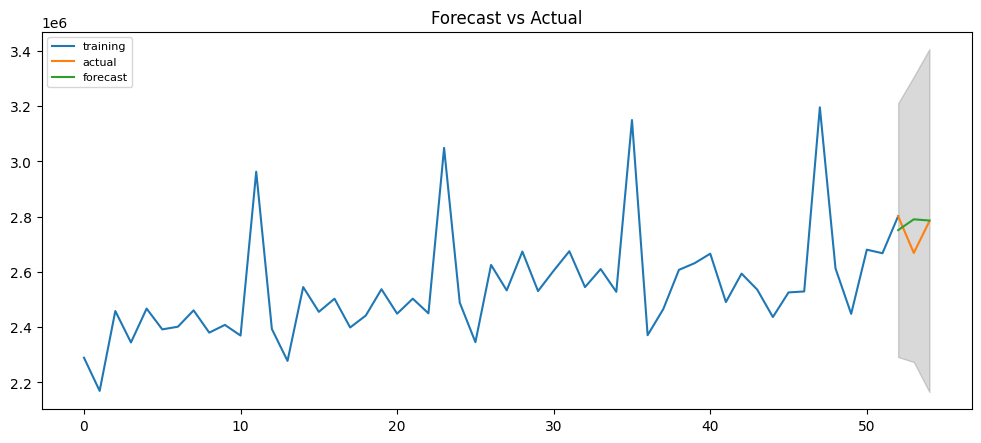

In [0]:
#Build Model
n_periodo = 3
p = pd.DataFrame([])
p.index =np.arange(len(train)-1,len(train)-1+n_periodo)
train = train.astype('float32')
model = ARIMA(train, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(n_periodo, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=p.index)
lower_series = pd.Series(conf[:, 0], index=p.index)
upper_series = pd.Series(conf[:, 1], index=p.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
fc_series.index = p.index
fc_series

Out[325]: 52    2.751424e+06
53    2.790559e+06
54    2.786194e+06
dtype: float64

In [0]:
test.values

Out[326]: array([2801884, 2668863, 2784026])

In [0]:
forecast_accuracy(fc, test.values)

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

Out[327]: {'mape': 0.021462210279257637,
 'me': 24467.852957718384,
 'mae': 58108.13785381274,
 'mpe': 0.009455901347091152,
 'rmse': 76072.05370320518,
 'acf1': -0.6073503107776238,
 'corr': -0.6812964181660787,
 'minmax': 0.020799160400187033}

In [0]:
expli = 100 - (np.mean(np.abs(fc - test.values)/np.abs(test.values))*100)
print("El modelo tiene una precisión de alrededor del {}".format(expli))

El modelo tiene una precisión de alrededor del 97.85377897207424
